# Imports

In [256]:
import pandas as pd 
import numpy as np
import tabulate as tbl
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

# Introdução

Aqui será realizado a leitura da base de dados e o tratamento das suas linhas

In [222]:
parquet_file = './database/payments.parquet3'

Ao ler o arquivo do projeto, é importante verificarmos o estado da base e como estão os detalhes de saúde do projeto.

Ex: linhas com valores nulos, não únicos e afins. 

In [257]:

paymentTable = pd.read_parquet(parquet_file, engine='pyarrow')
describe = paymentTable.describe(include='all')
summary = paymentTable.isna().sum().to_frame('quantity')
# summary
# ax = summary.plot(kind='bar', figsize=(15,15), color='red')
# labels = list(summary.quantity)
# rects = ax.patches
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 1000, label, ha="center", va="bottom" 
#     )

print(summary.to_markdown())


|                                |   quantity |
|:-------------------------------|-----------:|
| id                             |         31 |
| account_id                     |         30 |
| device_id                      |         32 |
| installation_id                |         32 |
| timestamp                      |         33 |
| device_age_ms                  |         32 |
| n_accounts_by_device_30d       |     183839 |
| value                          |         35 |
| sum_values_by_device_30d       |     218650 |
| sum_values_by_device_3d        |     218649 |
| sum_values_by_installation_30d |     113666 |
| sum_values_by_installation_3d  |     113665 |
| low_geo_chargeback_rate_30d    |       2749 |
| medium_geo_chargeback_rate_30d |       4652 |
| high_geo_chargeback_rate_30d   |      51052 |
| chargedback                    |         32 |


In [260]:
describe.to_markdown()

'|        |               id | account_id       | device_id        | installation_id   |        timestamp |    device_age_ms |   n_accounts_by_device_30d |      value |   sum_values_by_device_30d |   sum_values_by_device_3d |   sum_values_by_installation_30d |   sum_values_by_installation_3d |   low_geo_chargeback_rate_30d |   medium_geo_chargeback_rate_30d |   high_geo_chargeback_rate_30d |     chargedback |\n|:-------|-----------------:|:-----------------|:-----------------|:------------------|-----------------:|-----------------:|---------------------------:|-----------:|---------------------------:|--------------------------:|---------------------------------:|--------------------------------:|------------------------------:|---------------------------------:|-------------------------------:|----------------:|\n| count  | 648142           | 648143           | 648141           | 648141            | 648140           | 648141           |               464334       | 648138     |      

In [209]:
def notNaFilter(frame, column):
    for label in column:
        frame = frame[frame[label].notna()]
    return frame

def fillNaFilter(frame, column):
    for label in column:
        frame[label] = frame[label].fillna(0)
    return frame

def numericColumns(columns):
    for labels in columns:
        paymentTable[labels] = pd.to_numeric(paymentTable[labels], errors = 'coerce')
    return paymentTable

def sumColumns(columns, frame, axis):
    for labels in columns:
        aux = paymentTable.groupby([axis])[labels].sum()
        aux = aux.reset_index()
        frame['sum'+labels] = aux[labels]
    return frame
def sumValueCharged(columns, frame):
    for labels in columns:
        paymentTable['chargedback'] = paymentTable['chargedback'].astype(str)
        aux_charged = paymentTable.where(paymentTable['chargedback'] == '0.0').groupby(['account_id'])[labels].sum().reset_index(name = 'unchargedback_value')
        aux_uncharged = paymentTable.where(paymentTable['chargedback'] == '1.0').groupby(['account_id'])[labels].sum().reset_index(name = 'chargedback_value')
        frame = frame.join(aux_charged.set_index('account_id')[['unchargedback_value']], on='account_id')
        frame = frame.join(aux_uncharged.set_index('account_id')[['chargedback_value']], on='account_id')
    return frame
def plotBarChart(df,labels,title,labelX,color):
    fig, ax = plt.subplots()
    df.plot(kind='bar', figsize=(20,20), title=title, ax=ax, colors=color)
    rects = ax.patches
    labels = list(df[labelX])
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 1000, label, ha="center", va="bottom" 
        )
    ax.legend(labels)
    return
def plotPieChart(title,df,labels,colors):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    fig.set_facecolor('whitesmoke')
    patches, texts, percentage = ax.pie(df,wedgeprops=dict(width=1), colors=colors, startangle=90,autopct='%1.2f%%', radius=4)
    plt.legend(patches, labels, loc="center left", bbox_to_anchor=(2.3, 1, 1, 1), prop={'size': 15})
    ax.set_title(title, y=0.9, pad=-14)
    plt.show()
    return
def plotPieChart1(title,df,labels,colors):
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    fig.set_facecolor('whitesmoke')
    patches, texts, percentage = ax.pie(df,wedgeprops=dict(width=1), colors=colors, startangle=90,autopct='%1.2f%%', radius=4)
    plt.legend(patches, labels, loc="center left", bbox_to_anchor=(2.3, 1, 1, 1), prop={'size': 15})
    ax.set_title(title, y=0.9, pad=-14)
    plt.show()
    return
    
COLOR = 'black'
WEIGHT = "bold"
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['font.weight'] = WEIGHT
plt.rcParams['axes.titleweight'] = WEIGHT

In [210]:
notNaColumns = ['account_id', 'device_id', 'id']
fillNaColumns = ['n_accounts_by_device_30d', 'sum_values_by_device_30d', 'sum_values_by_device_3d', 'sum_values_by_installation_30d', 'sum_values_by_installation_3d','low_geo_chargeback_rate_30d',]


In [211]:
paymentTable.columns = [x.lower() for x in paymentTable.columns]
paymentTable = notNaFilter(paymentTable, notNaColumns)
paymentTable = fillNaFilter(paymentTable, fillNaColumns)
paymentTable['datetime'] = pd.to_datetime(paymentTable['timestamp'], unit='ms')
paymentTable
# pd.set_option('display.max_columns', None)


,id,account_id,device_id,installation_id,timestamp,device_age_ms,n_accounts_by_device_30d,value,sum_values_by_device_30d,sum_values_by_device_3d,sum_values_by_installation_30d,sum_values_by_installation_3d,low_geo_chargeback_rate_30d,medium_geo_chargeback_rate_30d,high_geo_chargeback_rate_30d,chargedback,datetime
0,103262188752,Qg1D8ImiasT1avXL,7MkfhkrM5b0zCXzO,MR8p/uS6dEX1KlLX,1.628347e+12,6.145809e+09,1.0,111.781008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2021-08-07 14:39:37.113999872
1,103262188753,7oDcXhI2gc9IY/O2,64aUkvZXE0l7rRYB,lkZEByfr7JB81M0z,1.631746e+12,9.177266e+09,1.0,137.111008,2602.661008,92.811008,2602.661008,92.811008,0.001159,0.004757,0.0,0.0,2021-09-15 22:51:40.532000000
2,103262188754,yCnksj2py9afMuyJ,j9MxfU8zaJSBAJJB,KwB8eOTyu/c1X/vo,1.625329e+12,1.192803e+10,0.0,145.601008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2021-07-03 16:10:07.782000128
3,103262188755,UdU8Tz5Vaqw4wpCH,GgWDCBqCa09125xz,/7CONsK63eeDR+bg,1.626374e+12,4.149963e+09,0.0,85.141008,0.000000,0.000000,57.931008,0.000000,0.000229,0.000000,0.0,0.0,2021-07-15 18:26:53.876000000
4,103262188756,zwb2WB1zI75ku8Z0,Hulxshcopdyf7gaA,qrvdkJ49Ej/kCgdu,1.625593e+12,1.558110e+08,1.0,189.251008,0.000000,0.000000,0.000000,0.000000,0.002429,0.000000,0.0,0.0,2021-07-06 17:44:18.071000064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648168,678787812880,2FZYxaEsDL9KAS1N,D0uSI5BM3tlswAFE,u6H2d03dYfiKSl+h,1.624784e+12,1.165889e+10,1.0,67.401008,358.711008,0.000000,358.711008,0.000000,0.007775,0.000000,0.0,0.0,2021-06-27 08:56:07.609999872
648169,678787812881,Xws5QLQvwGt+ZBQF,itiuc5Pt5qvI7MNA,TTM0TWuxzjZOEiqr,1.632059e+12,1.313333e+10,0.0,135.621008,6144.871008,2331.771008,6888.401008,2331.771008,0.000000,0.000000,0.0,0.0,2021-09-19 13:43:33.108999936
648170,678787812882,W8KG4v5XqoU8m8bq,GgWDCBqCa09125xz,yJhGEqVO9oqFHPgu,1.627999e+12,4.503700e+09,0.0,56.211008,0.000000,0.000000,574.481008,342.591008,0.001509,0.000000,0.0,0.0,2021-08-03 13:58:16.147000064
648171,678787812883,jYchlZ8hNb2Ig1f9,DtjuXioAmlu/5zGe,njuSOJTcsr8fWs4B,1.627151e+12,1.393045e+10,1.0,87.651008,198.611008,0.000000,198.611008,0.000000,0.000000,0.000000,NaN,0.0,2021-07-24 18:28:08.740999936


In [214]:
accountDevices = paymentTable.groupby('account_id')['device_id'].nunique().to_frame('device_count').reset_index()
listValueDevice =  accountDevices['device_count'].value_counts()
listValueDevice



1     109232
2       5560
3        496
4         88
5         19
6          7
12         2
21         2
9          2
13         1
8          1
7          1
Name: device_count, dtype: int64

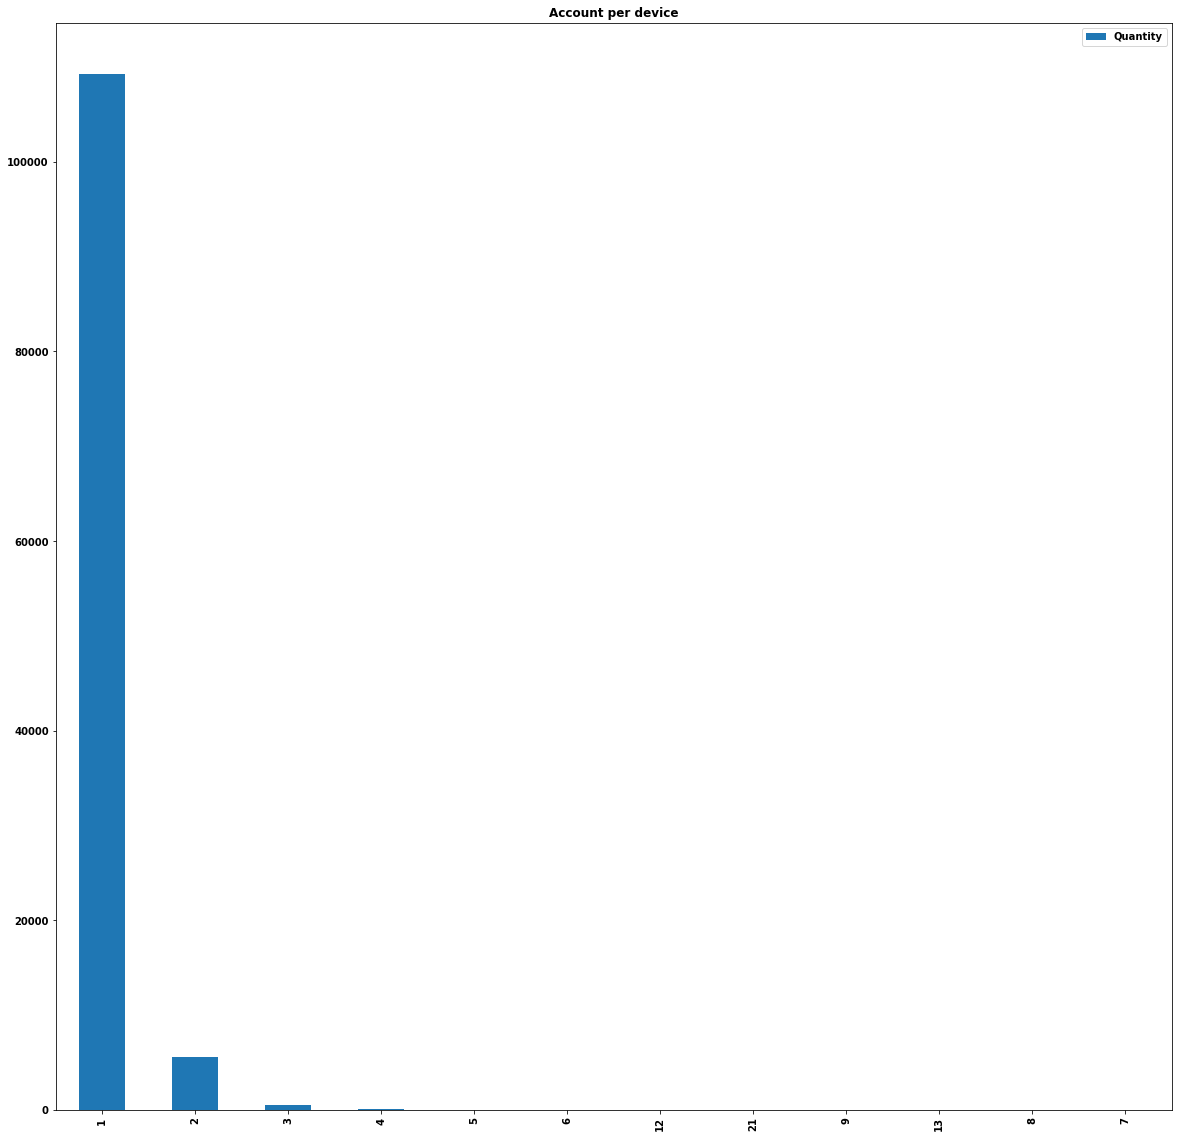

In [220]:
labels=['Quantity']
plotBarChart(listValueDevice,labels,'Account per device')

In [180]:
paymentTable['chargedback'] = pd.to_numeric(paymentTable['chargedback'], errors='coerce')
paymentTable  = paymentTable.loc[((paymentTable['chargedback'] <=1))]
paymentTable['chargedback'] = paymentTable['chargedback'].astype(str)

In [182]:
tableAccountIDChargedBackCount = paymentTable.groupby('account_id')['chargedback'].value_counts().to_frame('counts')
tableAccountIDChargedBackCount = tableAccountIDChargedBackCount.reset_index().drop('counts',1)
listValueChargedBack =  tableAccountIDChargedBackCount['chargedback'].value_counts()
listValueChargedBack

C:\Users\victo\AppData\Local\Temp/ipykernel_11732/809610350.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tableAccountIDChargedBackCount = tableAccountIDChargedBackCount.reset_index().drop('counts',1)


0.0    114948
1.0      1612
Name: chargedback, dtype: int64

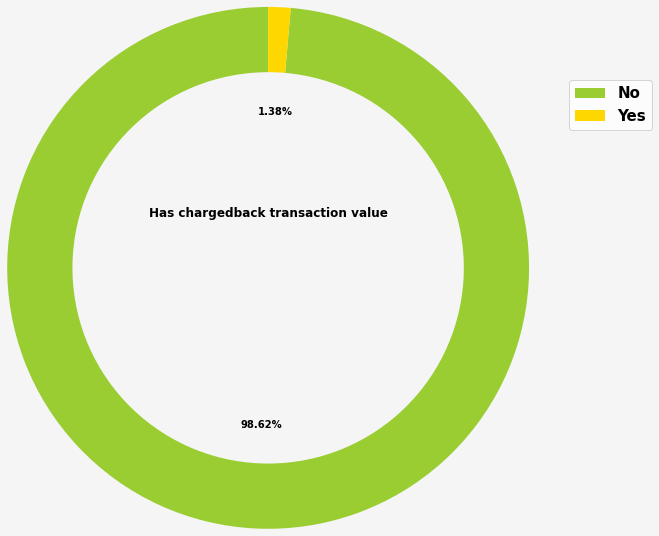

In [135]:
labels=['No', 'Yes']
colors = ['yellowgreen', 'gold']
plotPieChart('Has chargedback transaction value', listValueChargedBack, labels,colors) 

In [128]:
tableAccountID = paymentTable.groupby('account_id')['account_id'].count().to_frame('quantity').reset_index()
tableAccountID['quantity'] = pd.to_numeric(tableAccountID['quantity'], errors='coerce')
tableAccountID.dropna(subset =['quantity'], inplace=True)


In [130]:
sumUpColumnsLabels = ['value']

In [131]:

paymentTable = numericColumns(sumUpColumnsLabels)
tableAccountID = sumColumns(sumUpColumnsLabels, tableAccountID, 'account_id')
tableAccountID.dropna(subset =['sumvalue'], inplace=True)
tableAccountID = sumValueCharged(sumUpColumnsLabels, tableAccountID)
tableAccountID.dropna(subset =['quantity'], inplace=True)
tableAccountID.set_index('account_id', inplace=True)
tableAccountID['chargedback_value'] = tableAccountID["chargedback_value"].fillna(0)

tableAccountID

,quantity,sumvalue,unchargedback_value,chargedback_value
account_id,,,,
+++F5JdXBfV96KZ6,1,98.001008,98.001008,0.0
++1OYxeEe7SiKZkJ,12,977.612094,977.612094,0.0
++2dMAuOnDr1rG4l,1,263.501008,263.501008,0.0
++3eJlJ6p/5LhXg5,6,120.616047,120.616047,0.0
++3rynzBezPY5ZGl,2,40.842016,40.842016,0.0
...,...,...,...,...
zzsPFPlFkGi92dY0,3,154.203023,154.203023,0.0
zzvqBrxK7GQsXiHF,2,311.522016,311.522016,0.0
zzz6NM92xuPtN1pt,2,94.352016,94.352016,0.0


In [136]:
dfAccountFrequencyTotal = tableAccountID.copy()
dfAccountFrequencyTotal['quantity'] = dfAccountFrequencyTotal['quantity'].where(dfAccountFrequencyTotal['quantity'] > 200)
dfAccountFrequencyTotal.dropna(subset =['quantity'], inplace=True)


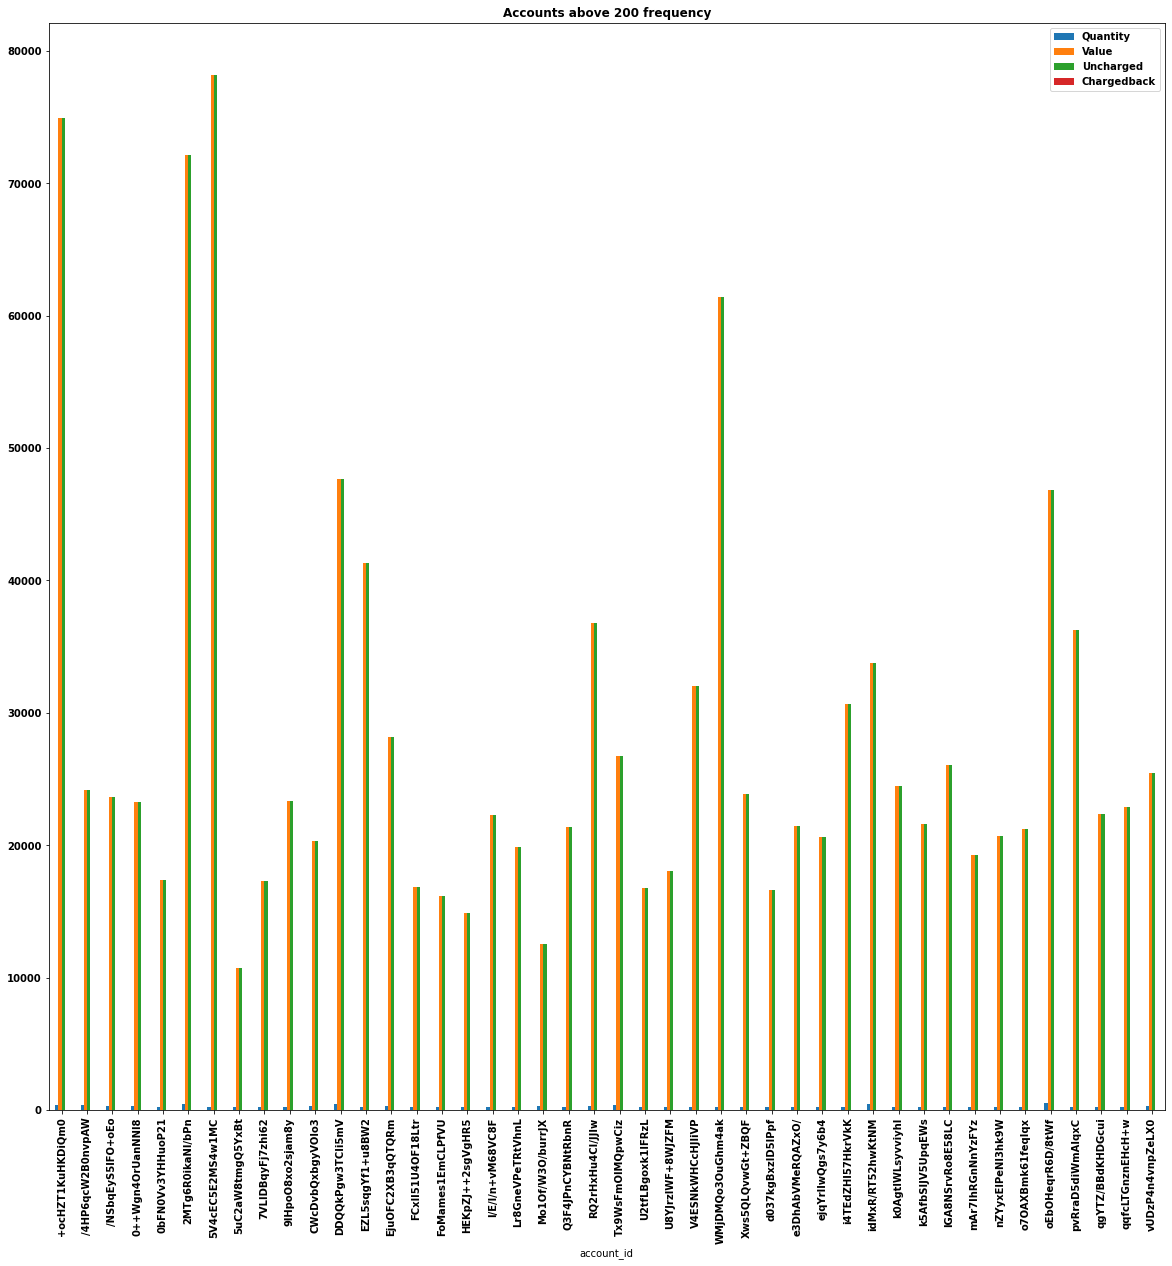

In [137]:
labels=['Quantity', 'Value', 'Uncharged', 'Chargedback']
plotBarChart(dfAccountFrequencyTotal,labels,'Accounts above 200 frequency')

In [ ]:
tableAccountChargedBack = tableAccountID

tableAccountChargedBack = tableAccountChargedBack[tableAccountChargedBack.chargedback_value > 0]

tableAccountChargedBack

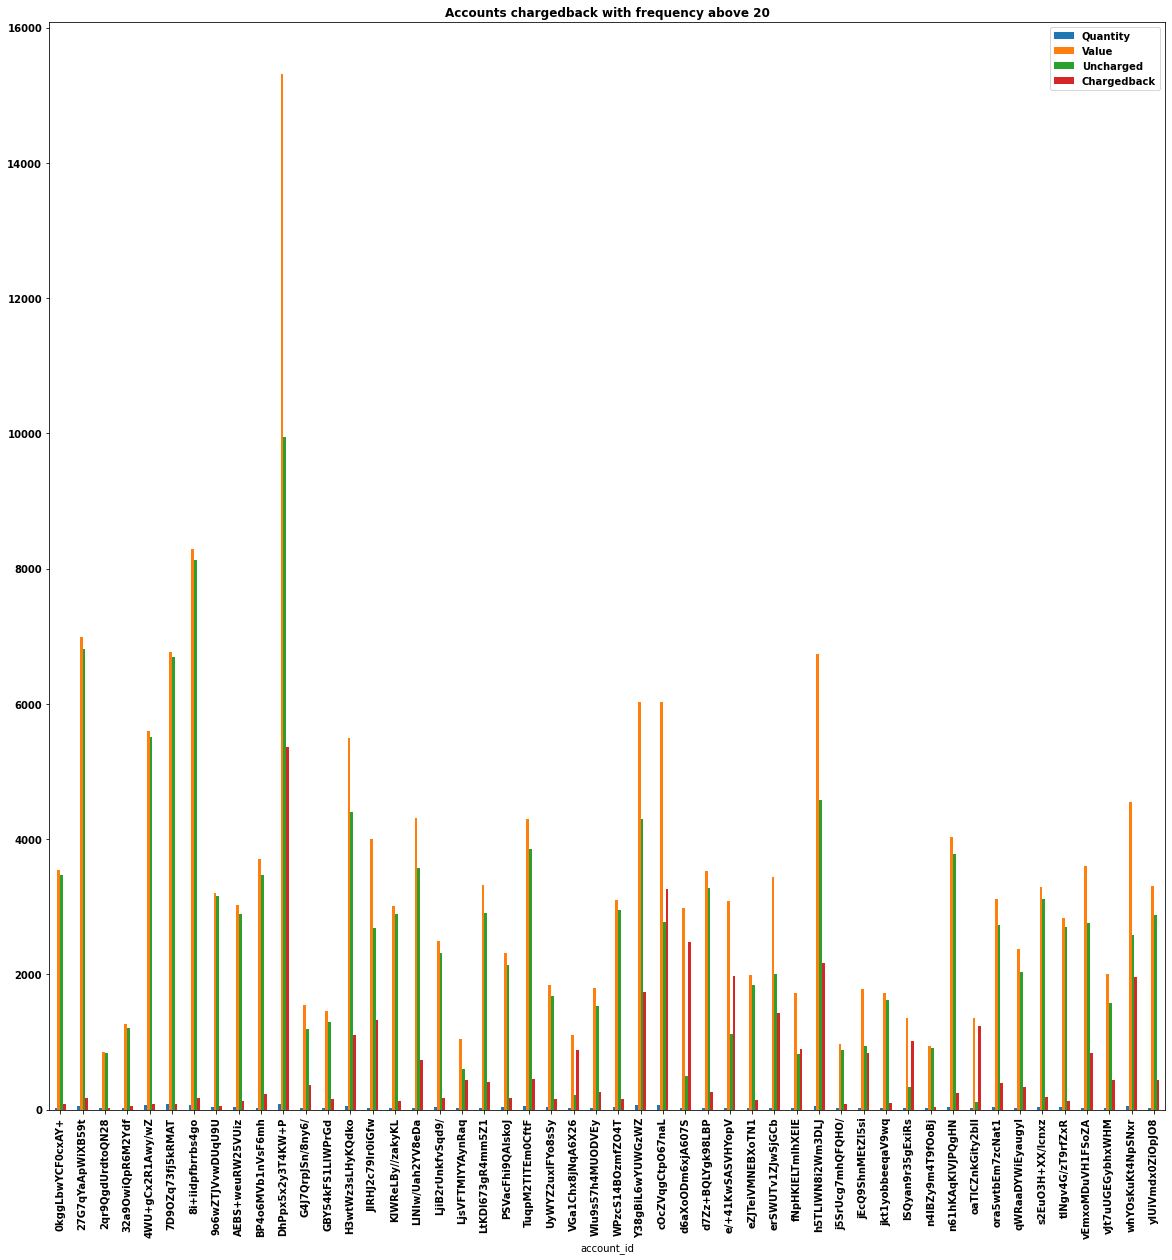

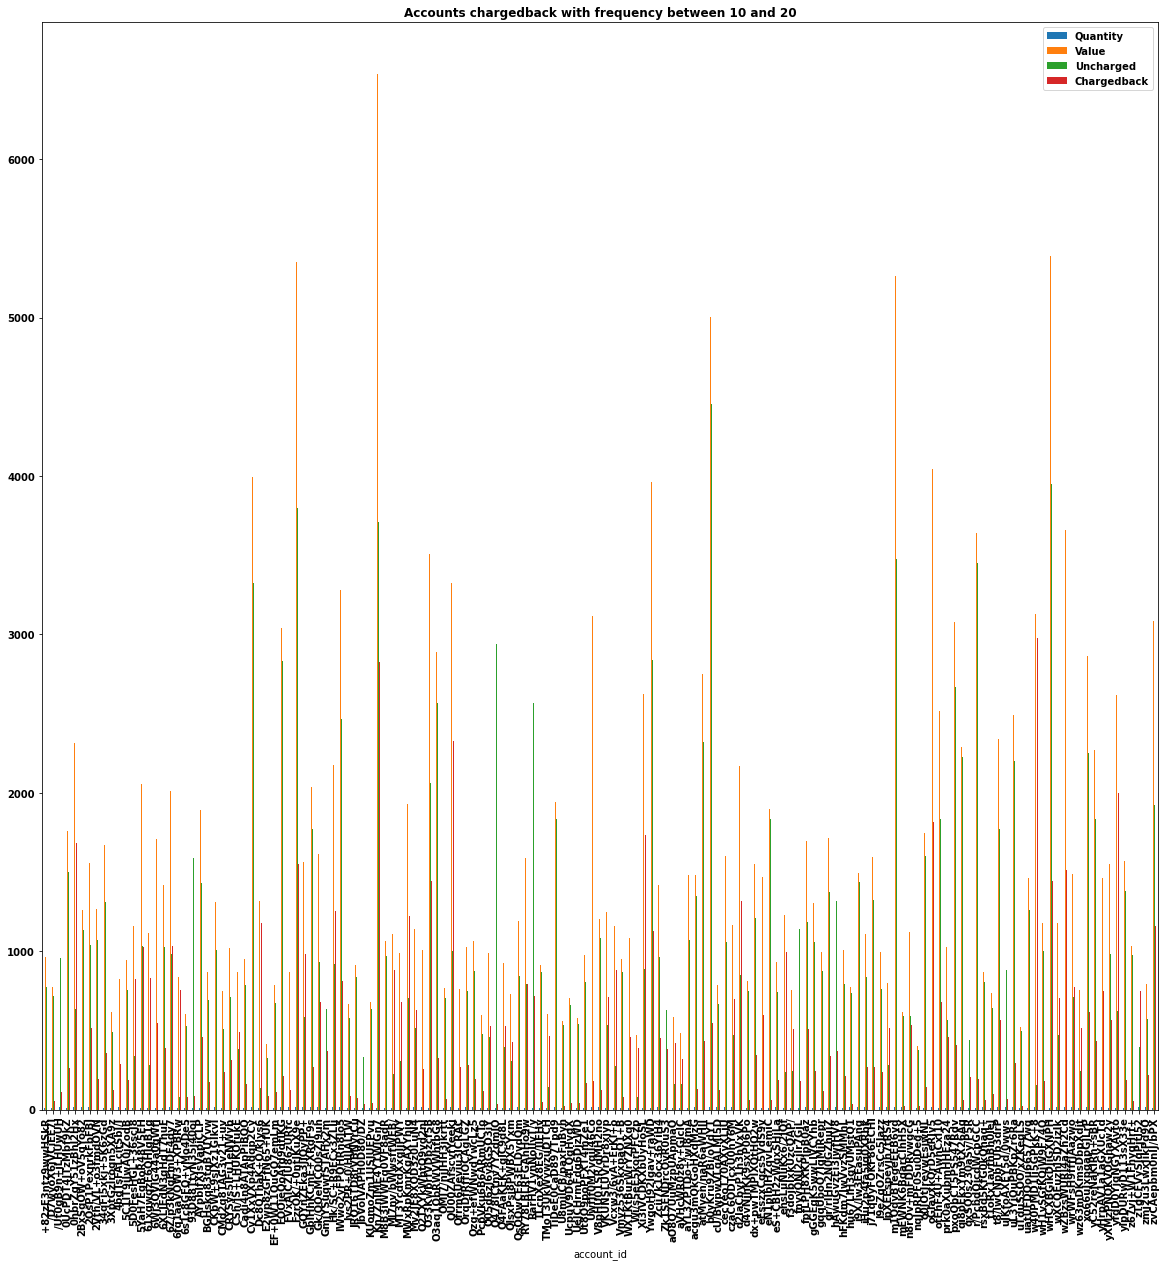

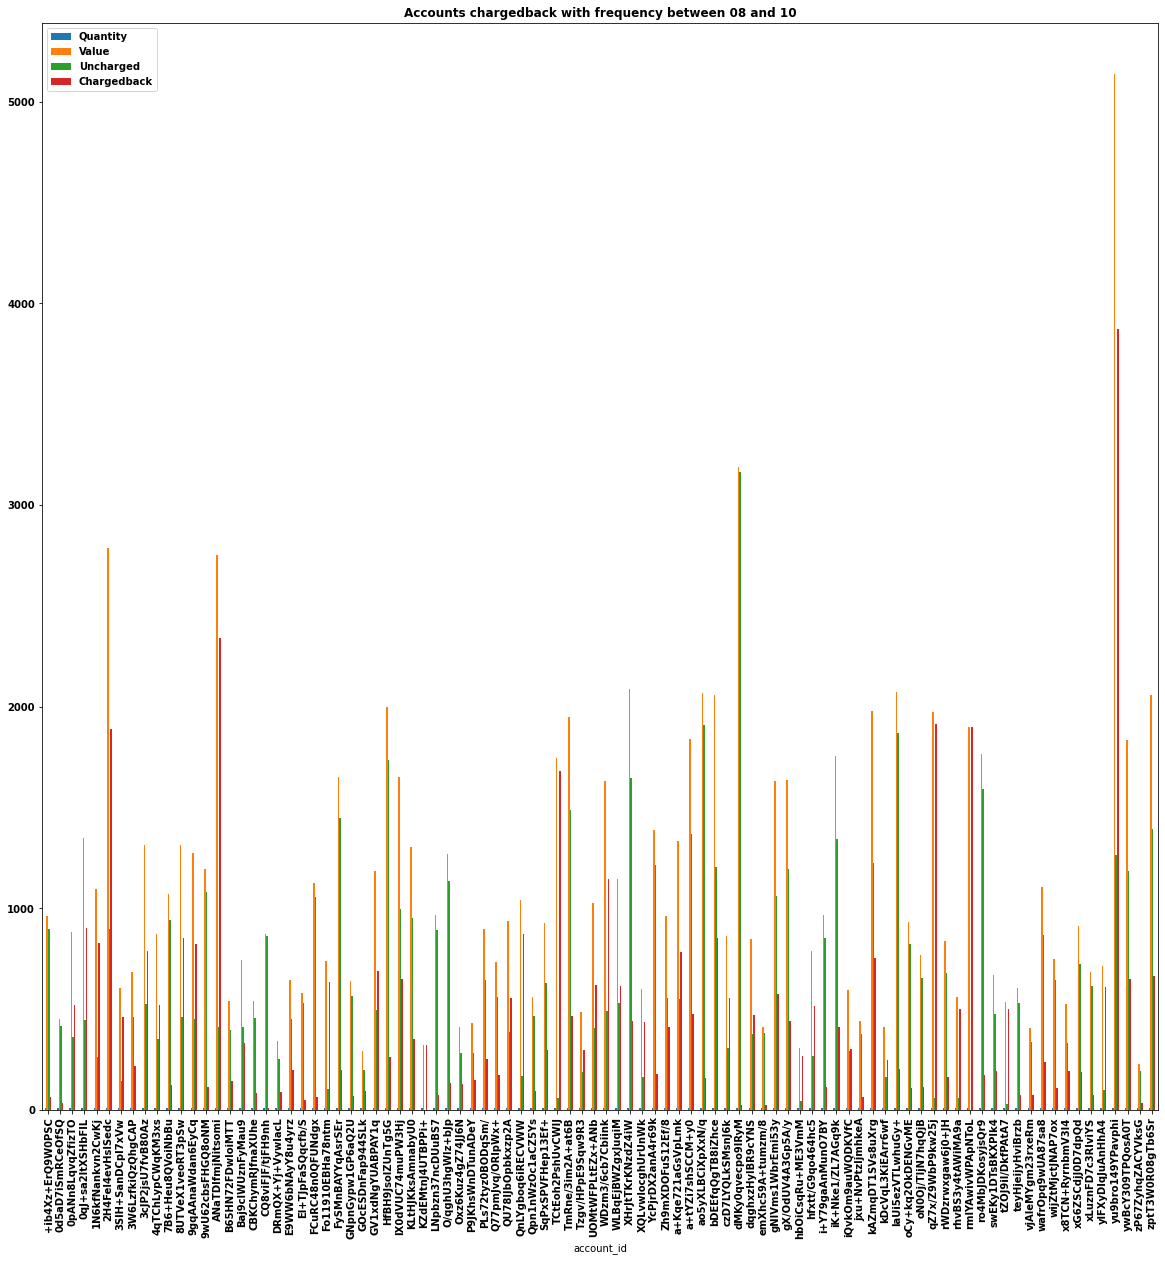

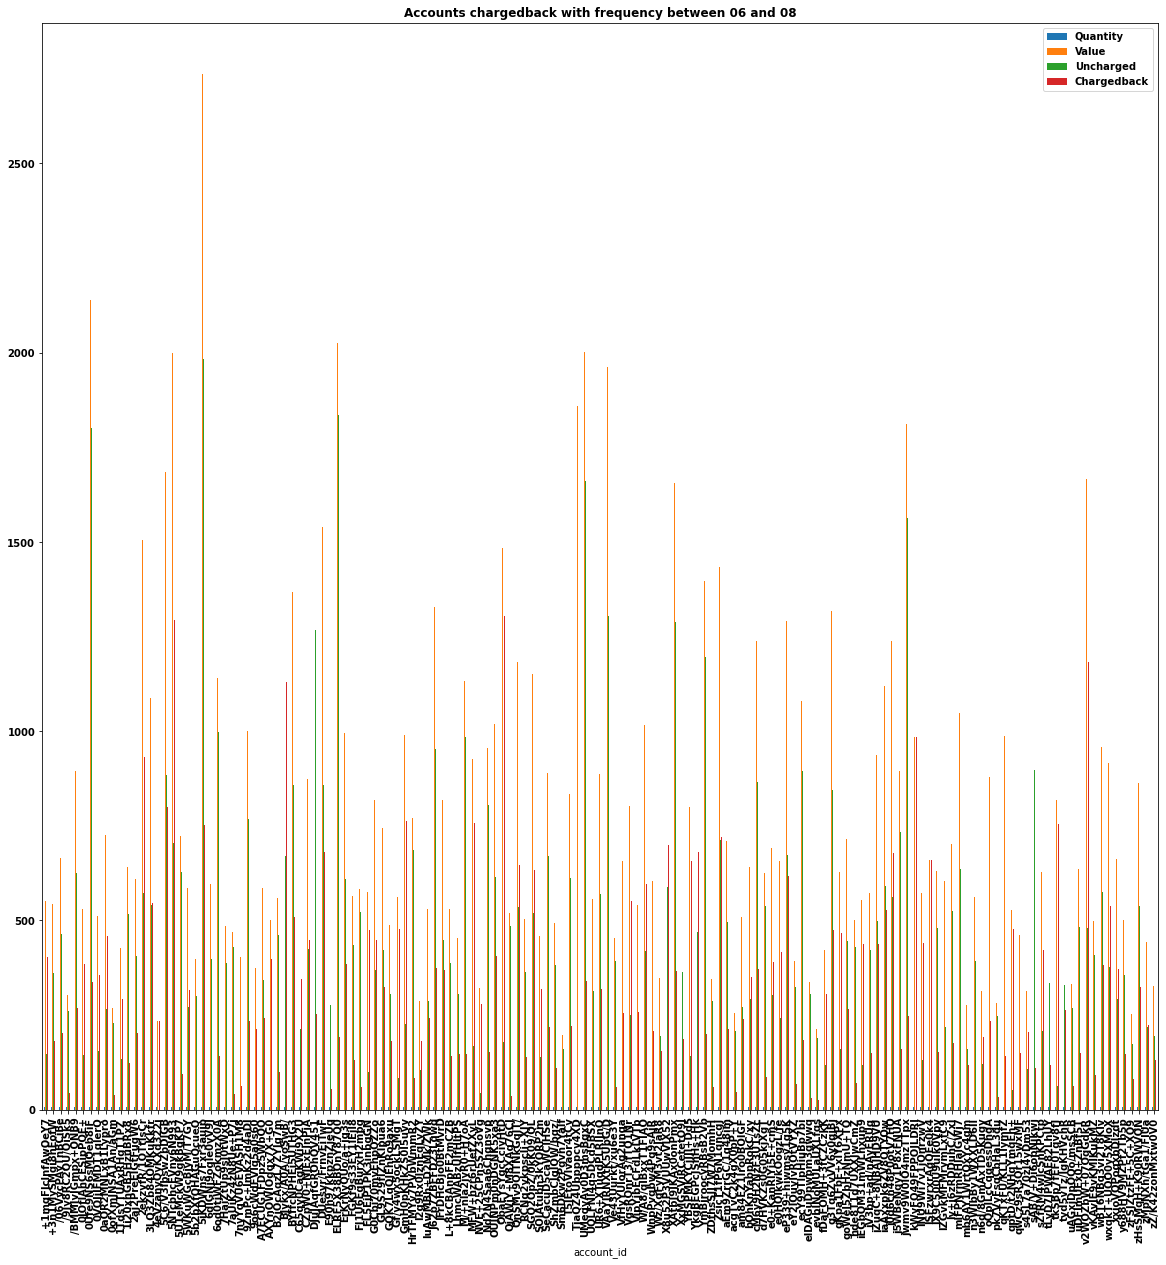

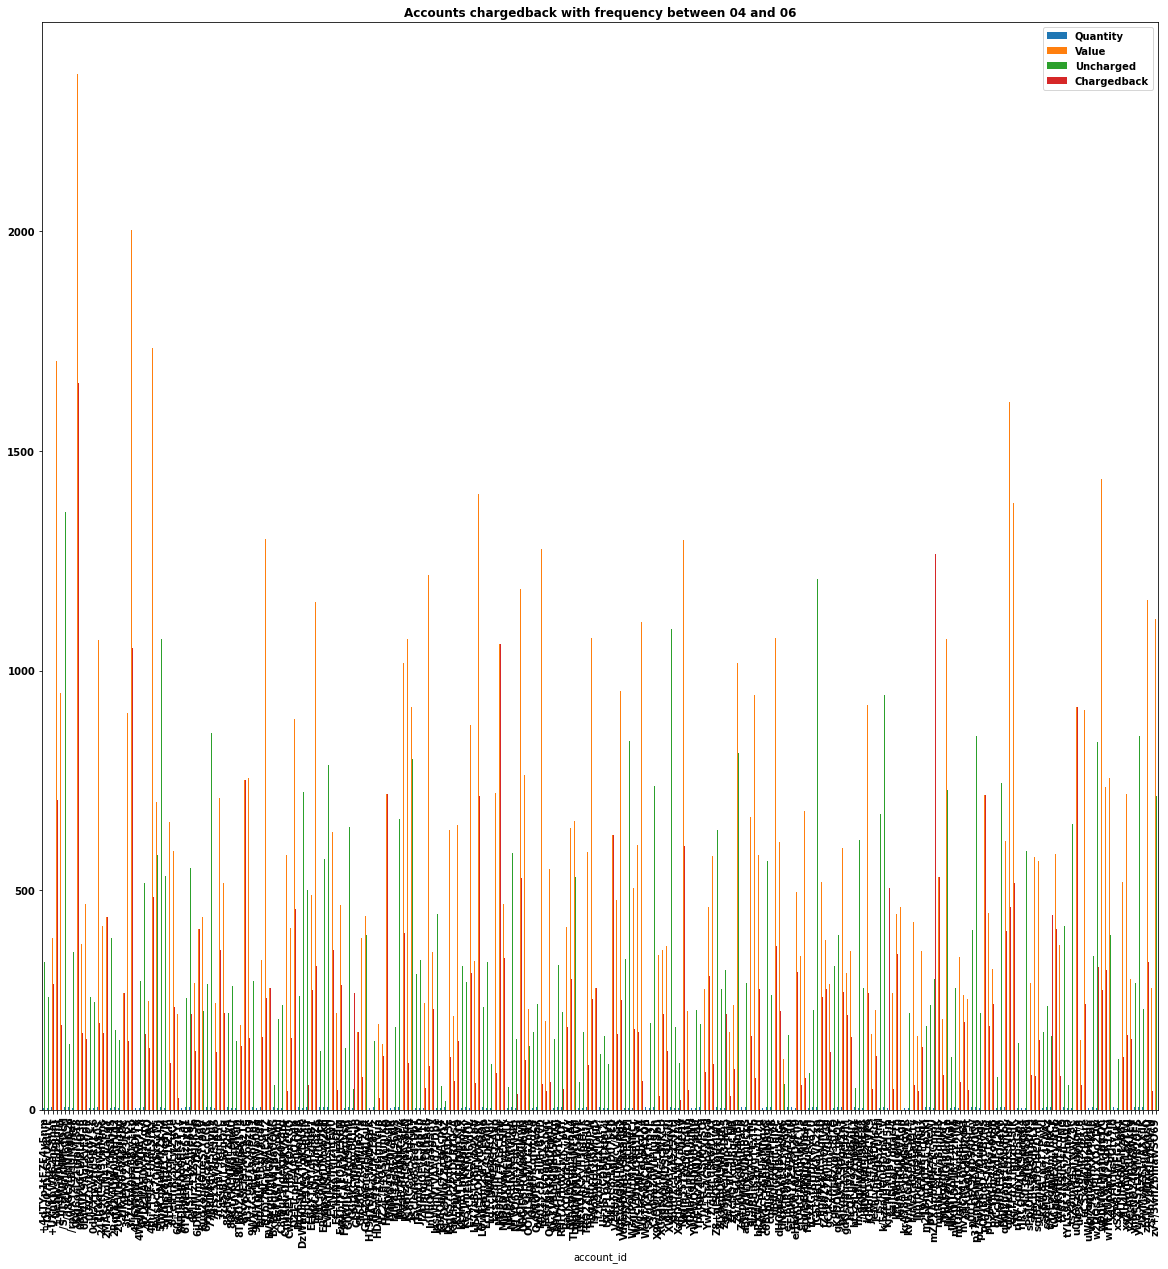

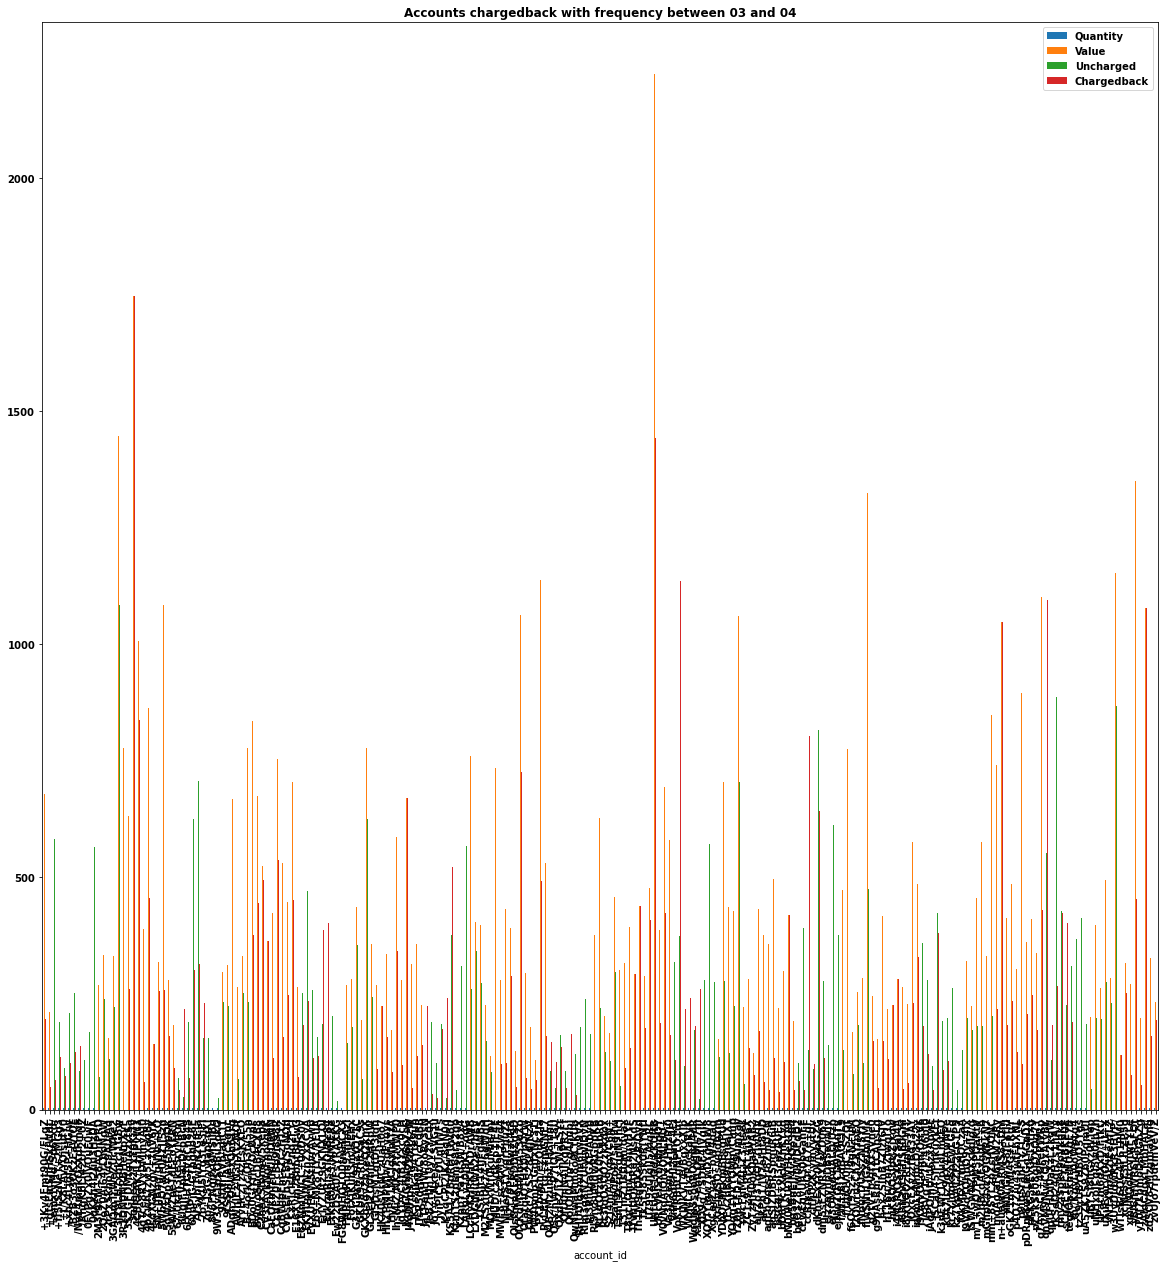

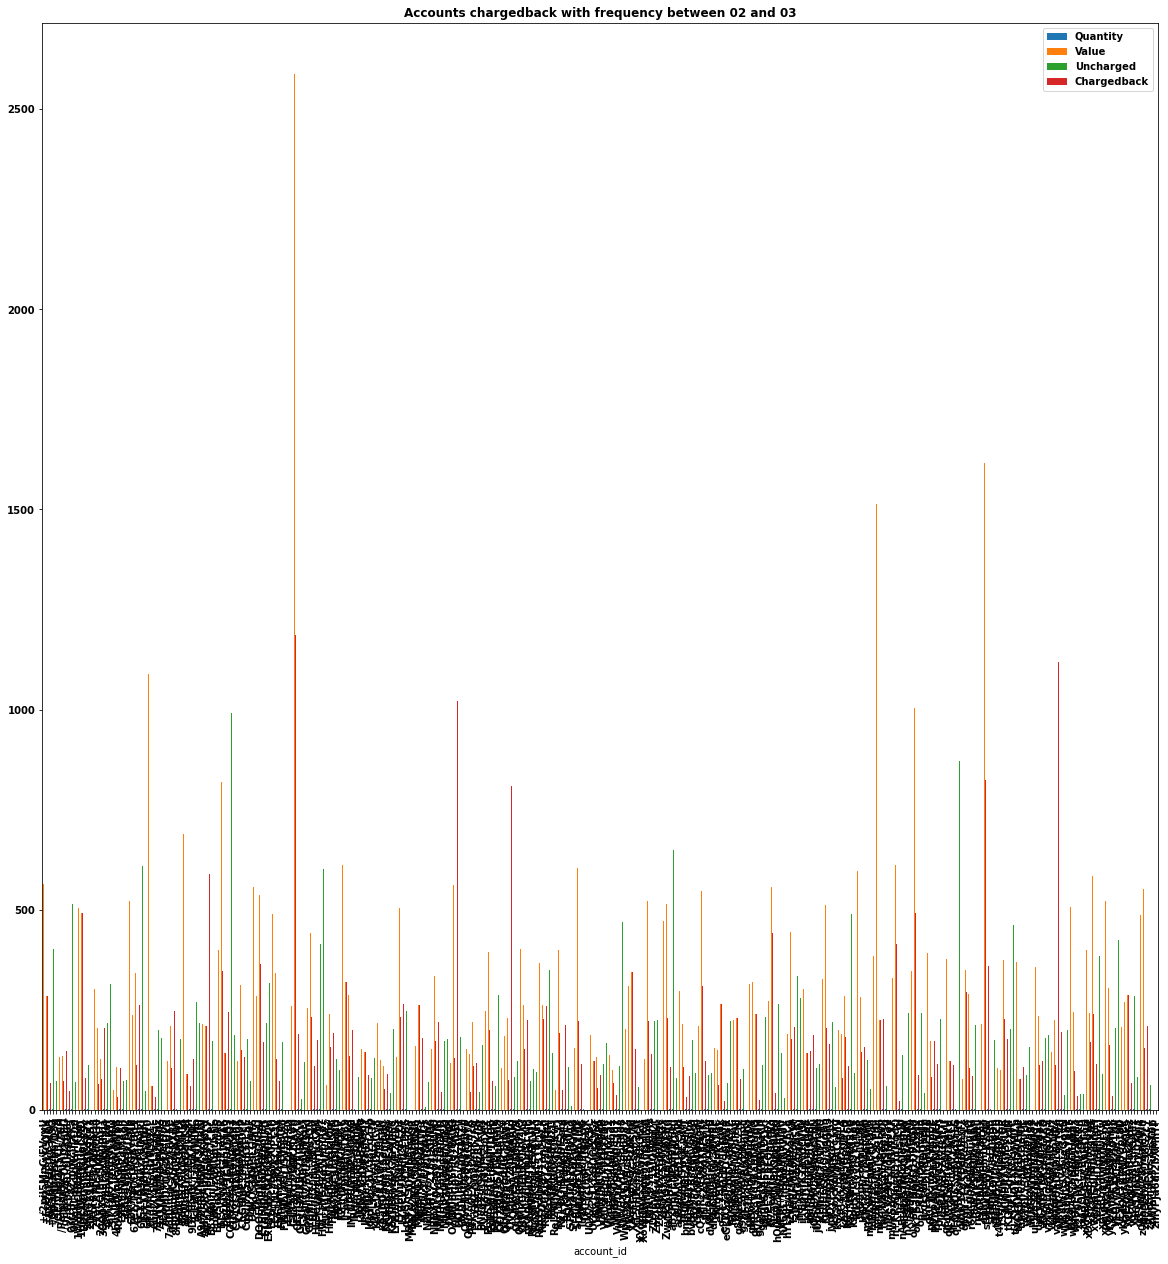

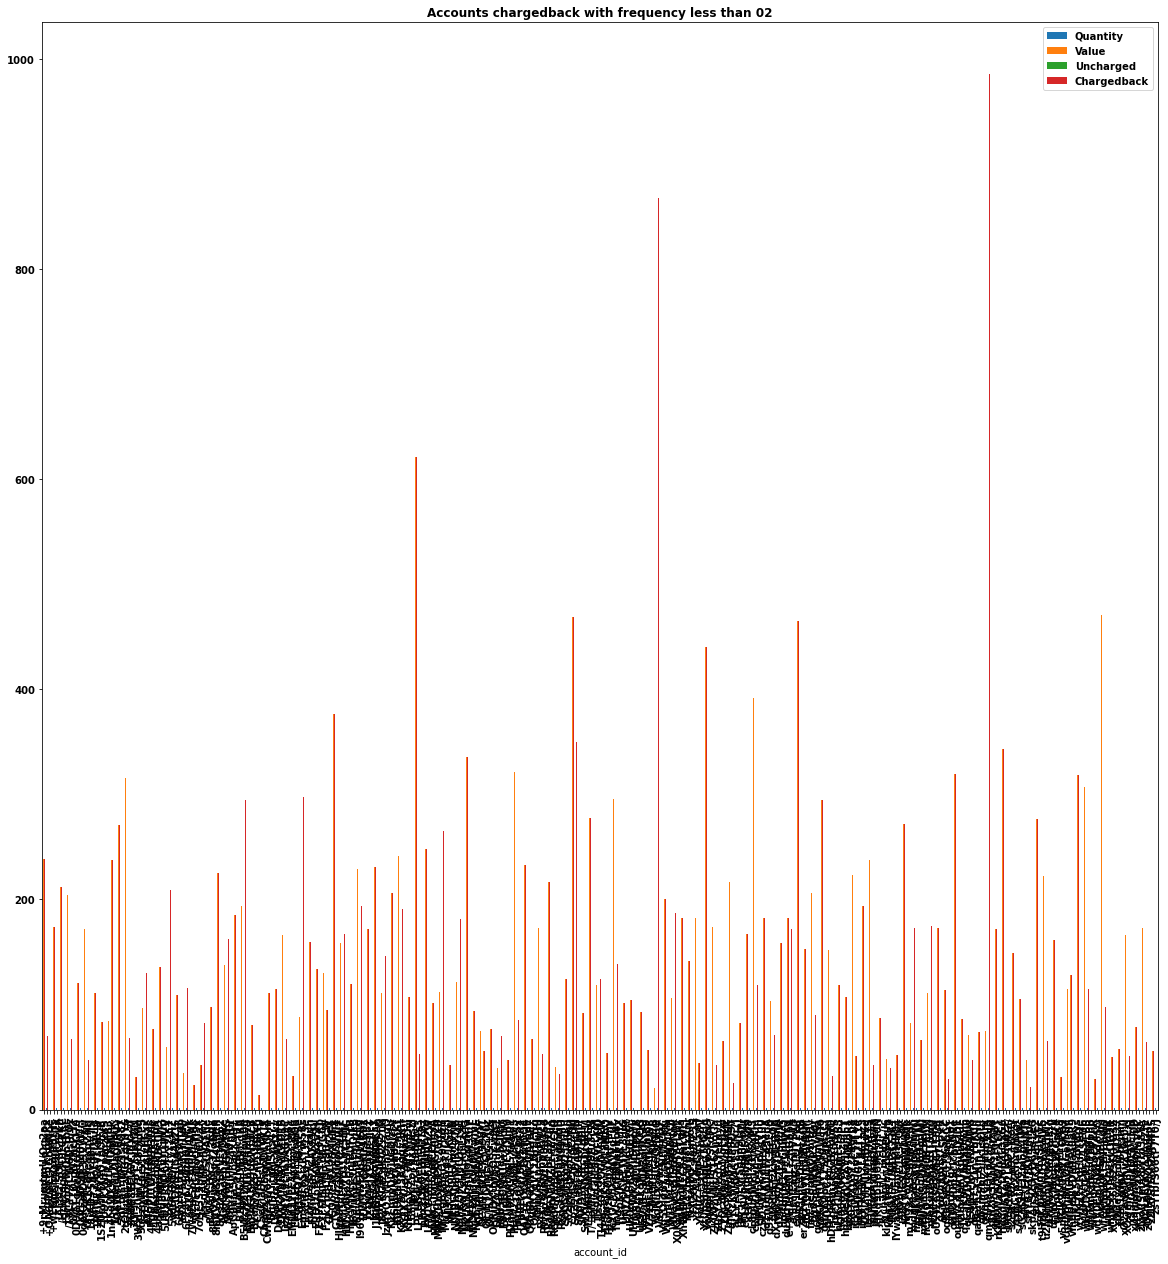

In [138]:
labels=['Quantity', 'Value', 'Uncharged', 'Chargedback']
tableAccountChargedBack20 = tableAccountChargedBack[tableAccountChargedBack.quantity >= 20]
tableAccountChargedBack1020 = tableAccountChargedBack[((tableAccountChargedBack.quantity >= 10) & (tableAccountChargedBack.quantity < 20))]
tableAccountChargedBack0810 = tableAccountChargedBack[((tableAccountChargedBack.quantity >= 8) & (tableAccountChargedBack.quantity < 10))]
tableAccountChargedBack0608 = tableAccountChargedBack[((tableAccountChargedBack.quantity >= 6) & (tableAccountChargedBack.quantity < 8))]
tableAccountChargedBack0406 = tableAccountChargedBack[((tableAccountChargedBack.quantity >= 4) & (tableAccountChargedBack.quantity < 6))]
tableAccountChargedBack0304 = tableAccountChargedBack[((tableAccountChargedBack.quantity >= 3) & (tableAccountChargedBack.quantity < 4))]
tableAccountChargedBack0203 = tableAccountChargedBack[((tableAccountChargedBack.quantity >= 2) & (tableAccountChargedBack.quantity < 3))]
tableAccountChargedBack02 = tableAccountChargedBack[(tableAccountChargedBack.quantity < 2)]

plotBarChart(tableAccountChargedBack20,labels,'Accounts chargedback with frequency above 20')
plotBarChart(tableAccountChargedBack1020,labels,'Accounts chargedback with frequency between 10 and 20')
plotBarChart(tableAccountChargedBack0810,labels,'Accounts chargedback with frequency between 08 and 10')
plotBarChart(tableAccountChargedBack0608,labels,'Accounts chargedback with frequency between 06 and 08')
plotBarChart(tableAccountChargedBack0406,labels,'Accounts chargedback with frequency between 04 and 06')
plotBarChart(tableAccountChargedBack0304,labels,'Accounts chargedback with frequency between 03 and 04')
plotBarChart(tableAccountChargedBack0203,labels,'Accounts chargedback with frequency between 02 and 03')
plotBarChart(tableAccountChargedBack02,labels,'Accounts chargedback with frequency less than 02')

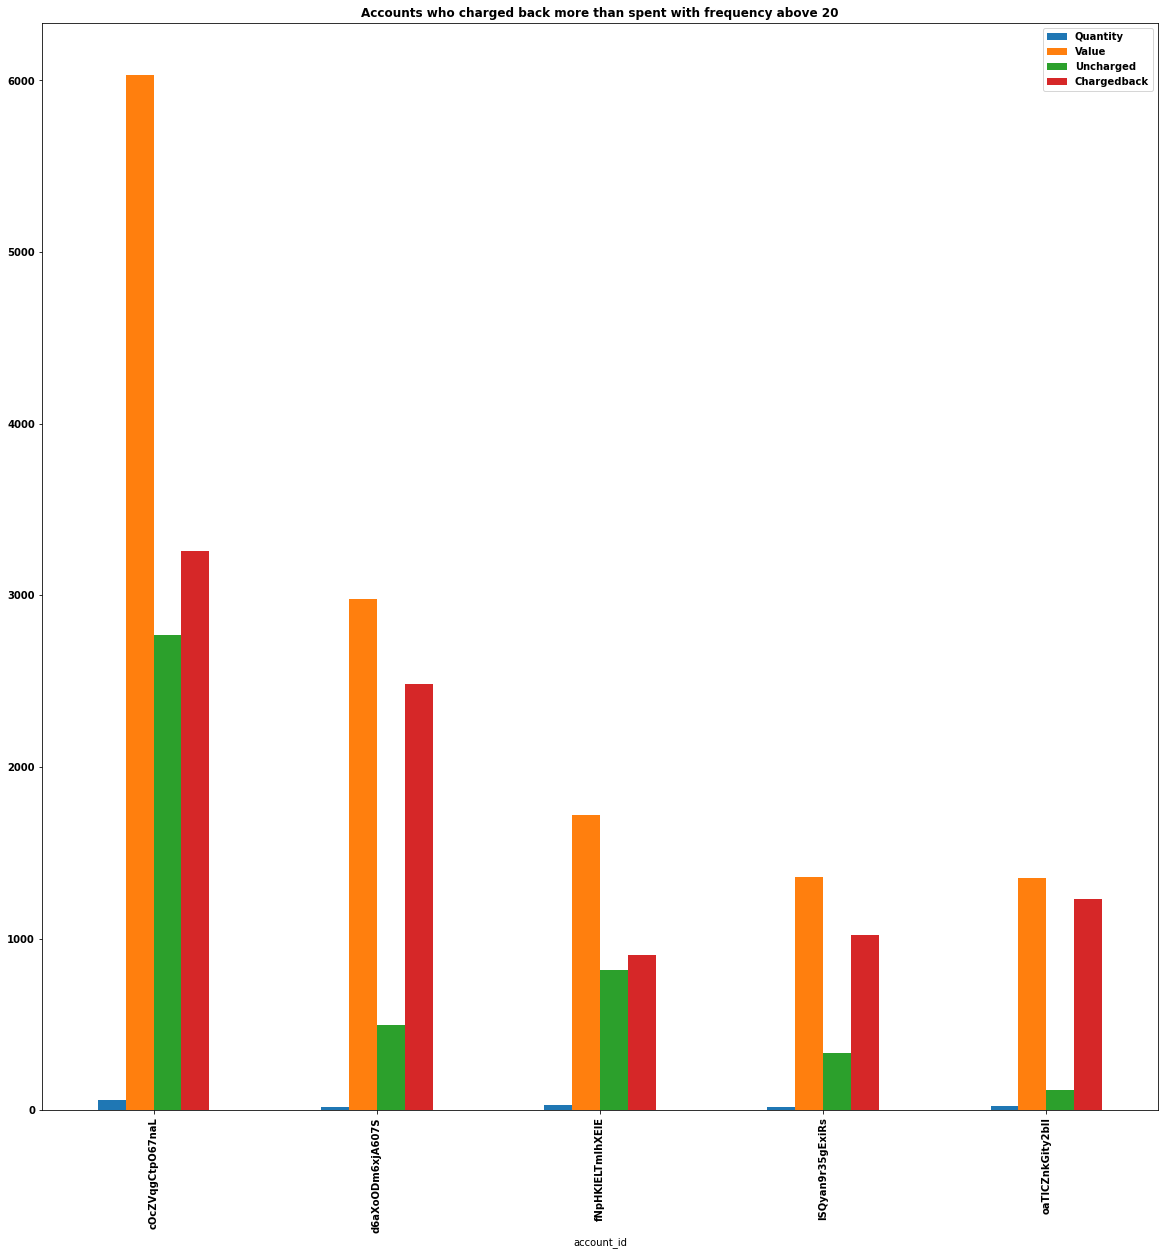

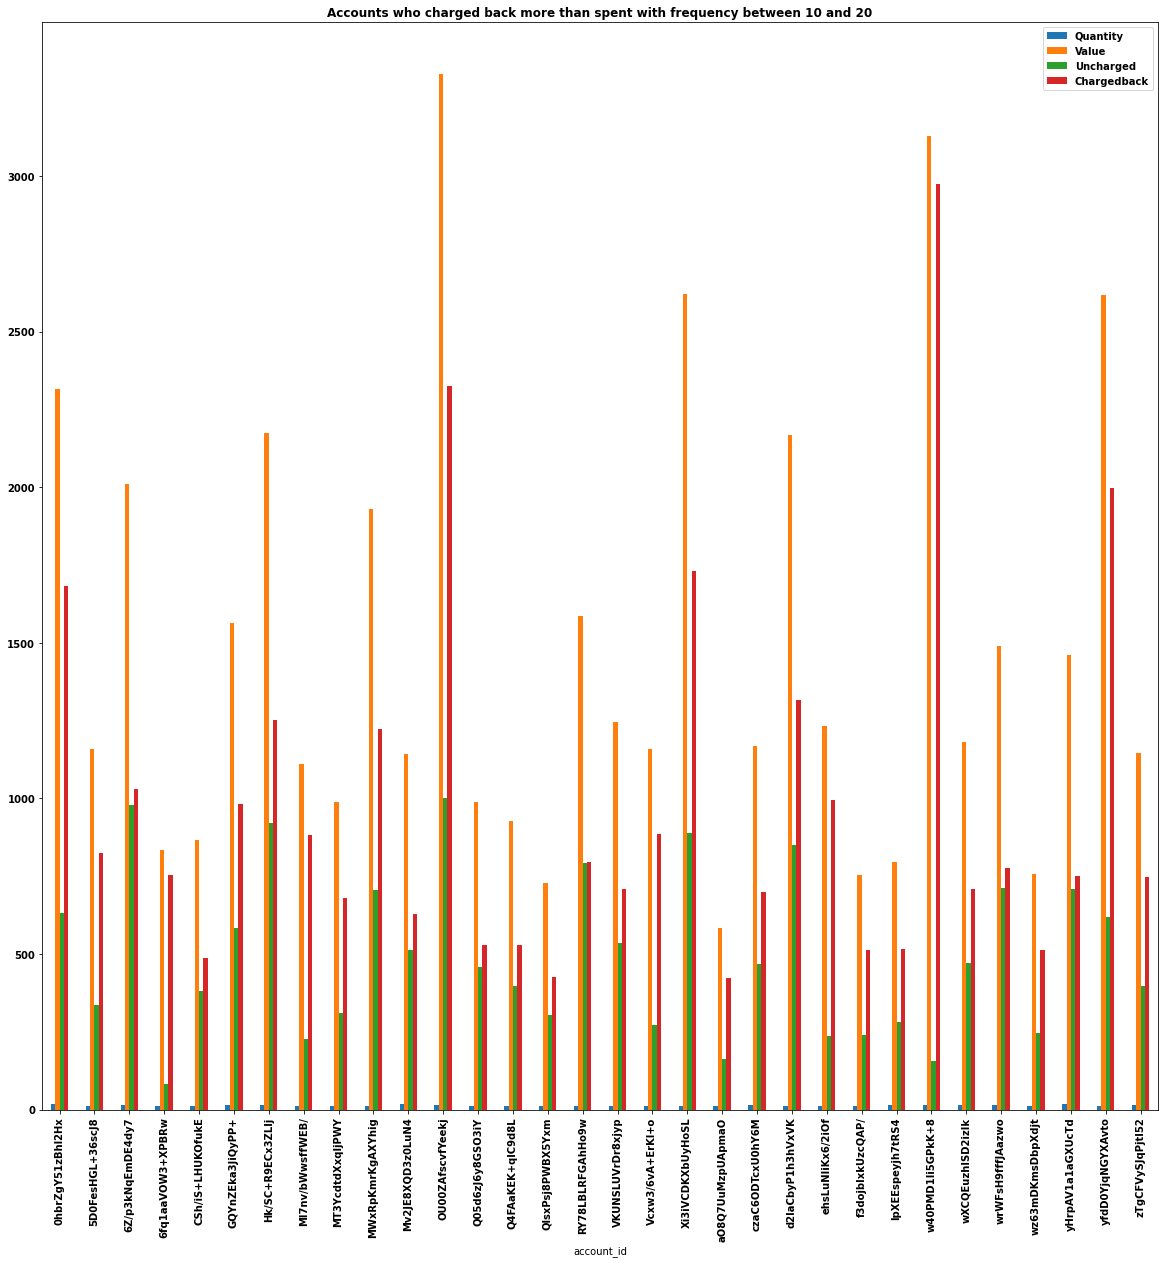

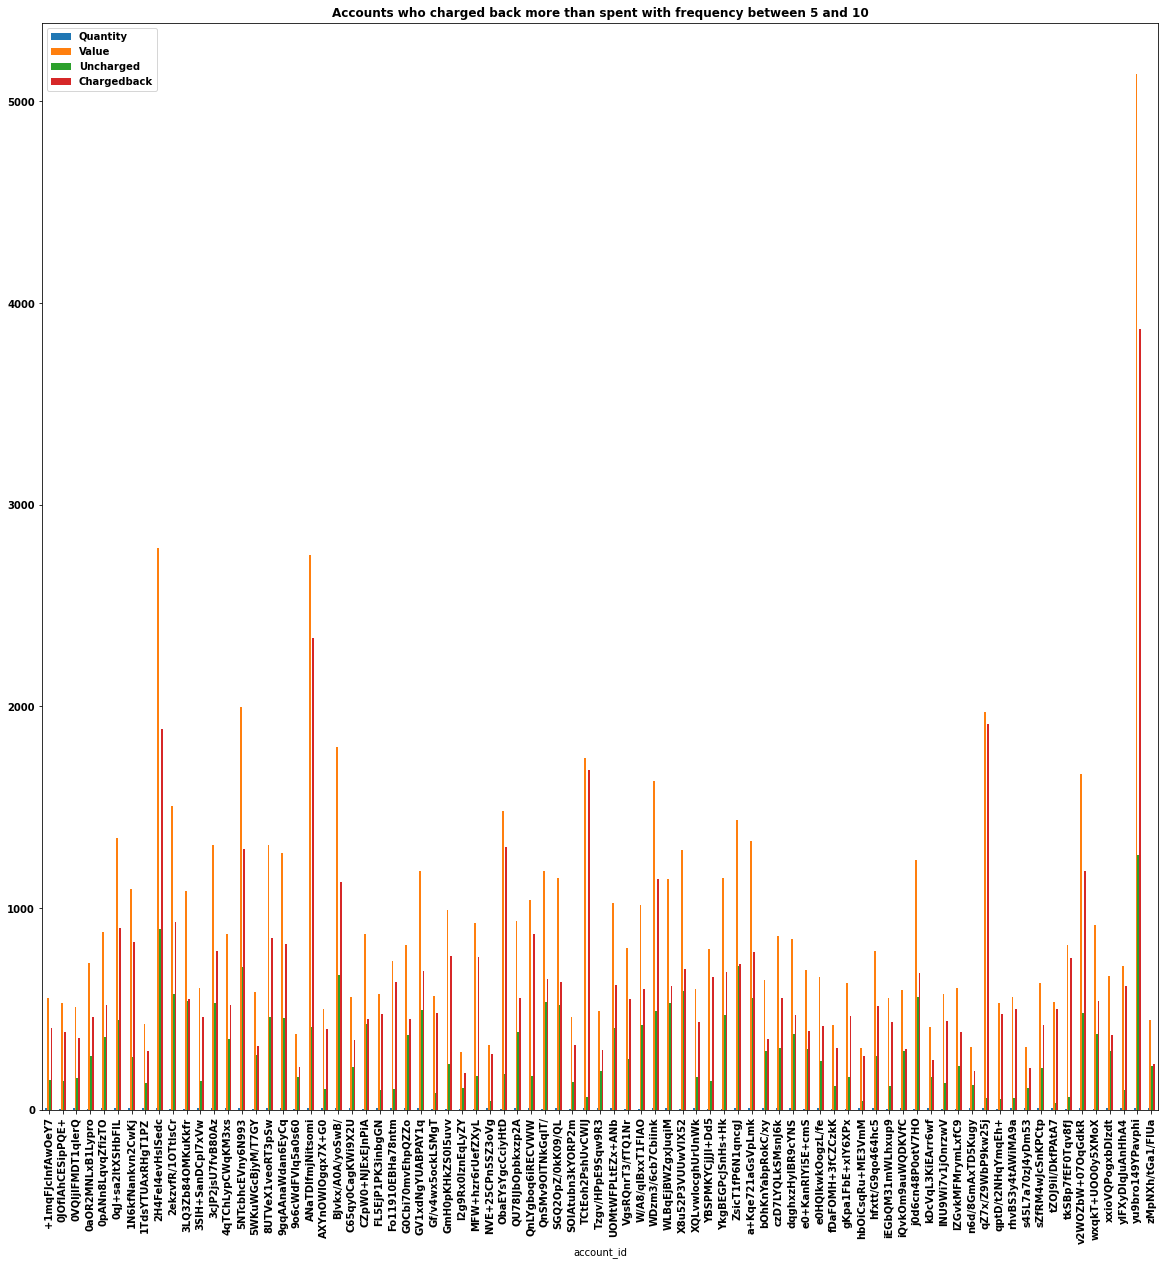

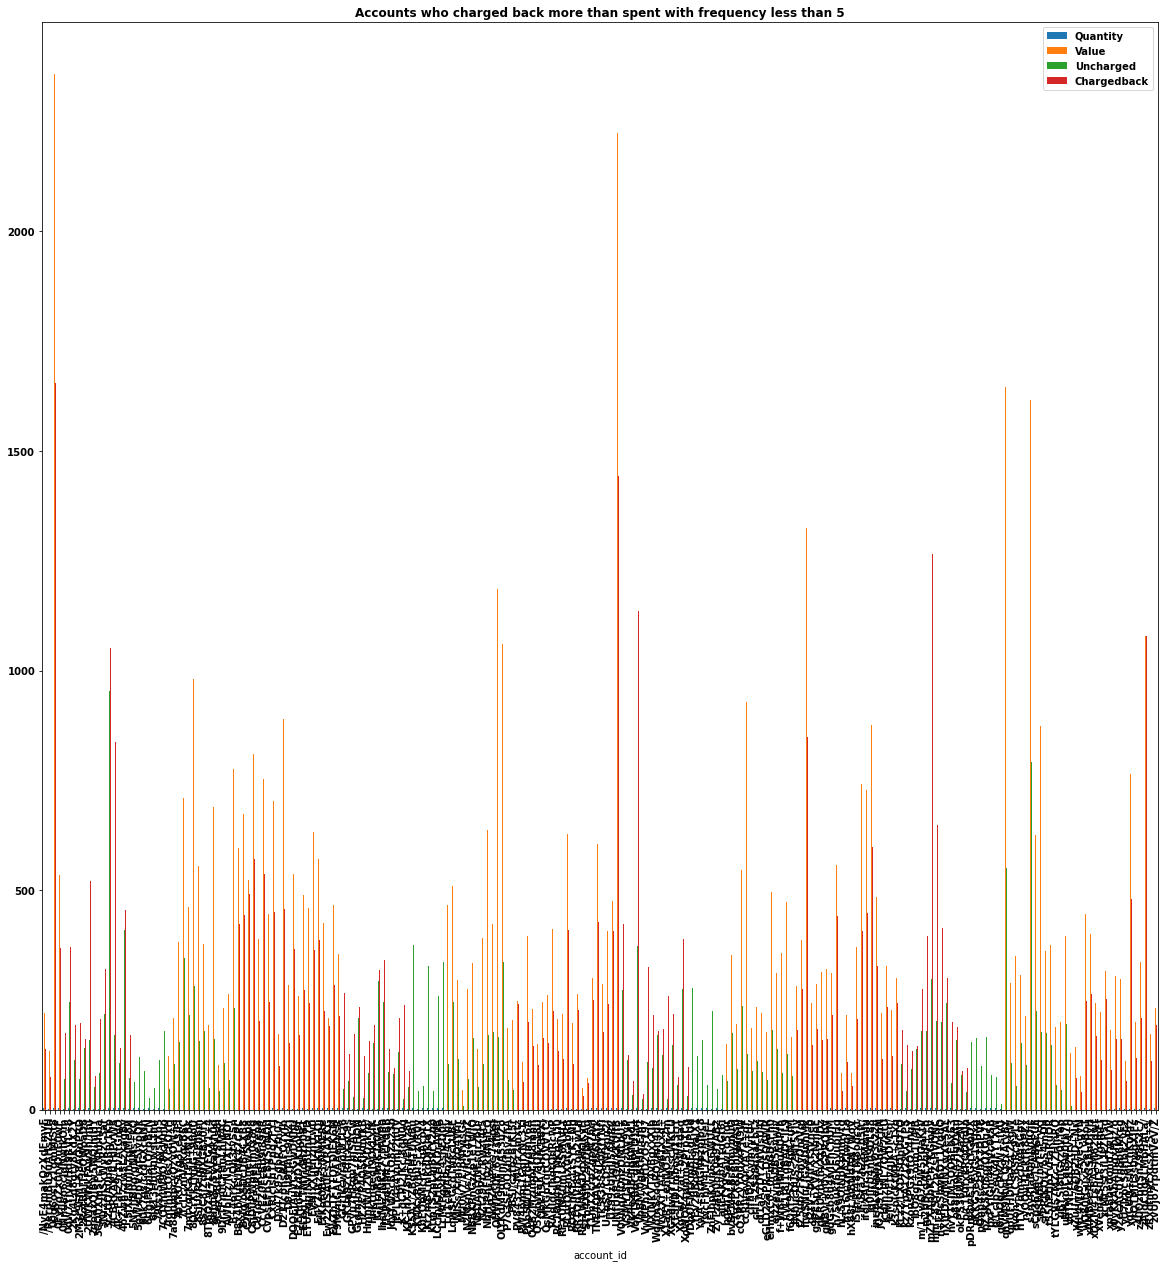

In [139]:
tableAccountChargedBack = tableAccountID.copy()
tableAccountChargedBack = tableAccountChargedBack[tableAccountChargedBack.chargedback_value > tableAccountChargedBack.unchargedback_value]
tableAccountChargedBack20 = tableAccountChargedBack[tableAccountChargedBack.quantity > 20]
tableAccountChargedBack1020 = tableAccountChargedBack[((tableAccountChargedBack.quantity > 10) & (tableAccountChargedBack.quantity < 20))]
tableAccountChargedBack0510 = tableAccountChargedBack[((tableAccountChargedBack.quantity > 5) & (tableAccountChargedBack.quantity < 10))]
tableAccountChargedBack05 = tableAccountChargedBack[(tableAccountChargedBack.quantity < 5)]


labels=['Quantity', 'Value', 'Uncharged', 'Chargedback']
plotBarChart(tableAccountChargedBack20,labels,'Accounts who charged back more than spent with frequency above 20')
plotBarChart(tableAccountChargedBack1020,labels,'Accounts who charged back more than spent with frequency between 10 and 20')
plotBarChart(tableAccountChargedBack0510,labels,'Accounts who charged back more than spent with frequency between 5 and 10')
plotBarChart(tableAccountChargedBack05,labels,'Accounts who charged back more than spent with frequency less than 5')

In [140]:
paymentCopy = paymentTable.copy()
paymentCopy['timestamp'] = pd.to_datetime(paymentCopy['timestamp'], unit='ms')
dfTransactionsDateChargedBack = paymentCopy.loc[((paymentCopy['timestamp'].dt.year >= 2021))
                     & (paymentCopy['timestamp'].dt.year < 2022) & (paymentCopy['timestamp'].dt.month != 4) ]
dfTransactionsDateTotal = paymentCopy.loc[((paymentCopy['timestamp'].dt.year >= 2021))
                     & (paymentCopy['timestamp'].dt.year < 2022)]
dfMonthChargedBack = dfTransactionsDateChargedBack.where(dfTransactionsDateChargedBack.chargedback == '1.0')['timestamp'].groupby(dfTransactionsDateChargedBack.timestamp.dt.to_period("M")).agg('count')
dfMonthTotal = dfTransactionsDateTotal['timestamp'].groupby(dfTransactionsDateTotal.timestamp.dt.to_period("M")).agg('count')

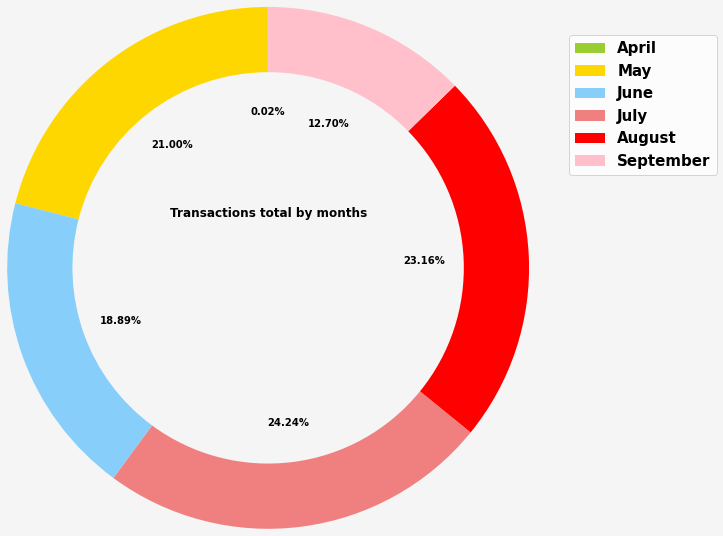

In [143]:
labelsMonths = 'April', 'May', 'June', 'July', 'August', 'September'
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red', 'pink']
plotPieChart('Transactions total by months', dfMonthTotal, labelsMonths, colors)


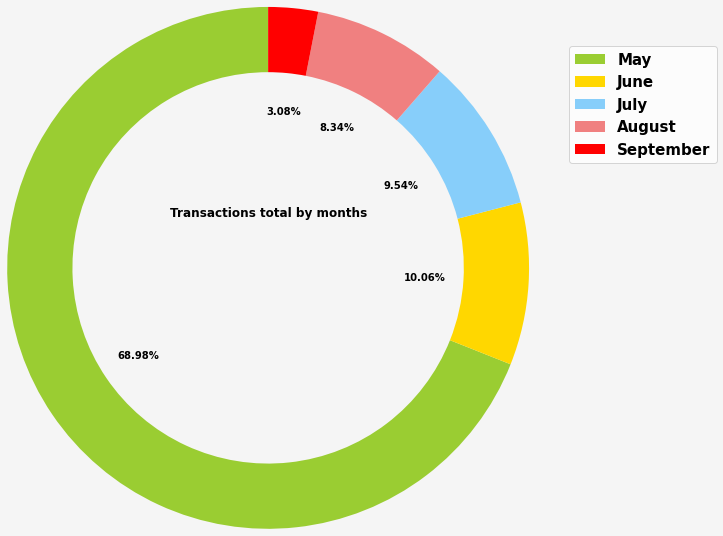

In [144]:

labelsMonths = 'May', 'June', 'July', 'August', 'September'
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'red']
plotPieChart('Transactions who charged back by months', dfMonthChargedBack, labelsMonths, colors)